In [2]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime
import statistics

In [3]:
# pd.set_option('display.max_rows', None) # 전체 행 보기
pd.options.display.max_rows = 90 # 적당히
pd.options.display.max_columns = 45

In [184]:
# JS, CMPS, SSJD, SSNC. 결측치 및 이상 데이터를 포함하는 행을 제외한 Internal Sound 열
filesinJS = [] # 수집된 파일 이름을 알 수 있는 목록을 만들 거예요. 변수 A_0531_232959의 데이터 프레임이 들어갈 예정이라는 것.
filesinCMPS = []
filesinSSJD = []
filesinSSNC = []
filenamesinJS = []
filenamesinCMPS = []
filenamesinSSJD = []
filenamesinSSNC = []
faulttypelist = ['JS', 'CMPS', 'SSJD', 'SSNC'] # 결함 유형
for faulttype in faulttypelist:
    os.chdir("C:\\Users\\99kit\\Desktop\\라즈베리파이제발\\Belt_"+faulttype)
    filelist = glob.glob('**/*.txt', recursive=True) # 결함 유형 폴더에서 불러온 모든 txt 파일
    len(filelist) # 3768, 3417, 3530, 3556
    num = 0
    for i in range(len(filelist)):
        currentfile = datetime.datetime(2023, int(filelist[i][:2]), int(filelist[i][3:5]), int(filelist[i][6:8]), int(filelist[i][9:11]), int(filelist[i][12:14]))
        with open(filelist[i], 'r') as file:
            data = []
            for line in file:
                values = line.strip().split(',')
                if len(values)==3:
                    data.append(values) # Internal Sound, Ambient Temmp., Target Temp. 열에 값이 없거나 보다 많은 개수의 값이 존재하는 행은 버릴 것입니다.
            globals()['A_'+currentfile.strftime("%m%d_%H%M%S")] = pd.DataFrame(data, columns=['Internal Sound', 'Ambient Temp.', 'Target Temp.']) # 동적 변수 생성
            globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Internal Sound'] = globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Internal Sound'].astype(int)
            # globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Ambient Temp.'] = globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Ambient Temp.'].astype(float) # 온도 데이터 필요할 때 살리세요.
            # globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Target Temp.'] = globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Target Temp.'].astype(float)
            globals()['A_'+currentfile.strftime("%m%d_%H%M%S")] = pd.DataFrame(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")].loc[:, 'Internal Sound']) # 온도 데이터 필요할 때 죽이세요.
            globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Time'] = currentfile # Time 열 추가. 모든 행이 같은 시각.
            globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Time'] = pd.to_datetime(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")]['Time'])
            if faulttype == 'JS':
                filesinJS.append(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")])
                filenamesinJS.append('A_'+currentfile.strftime("%m%d_%H%M%S")) # 보험이에요.
            elif faulttype == 'CMPS':
                filesinCMPS.append(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")])
                filenamesinCMPS.append('A_'+currentfile.strftime("%m%d_%H%M%S"))
            elif faulttype == 'SSJD':
                filesinSSJD.append(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")])
                filenamesinSSJD.append('A_'+currentfile.strftime("%m%d_%H%M%S"))
            elif faulttype == 'SSNC':
                filesinSSNC.append(globals()['A_'+currentfile.strftime("%m%d_%H%M%S")])
                filenamesinSSNC.append('A_'+currentfile.strftime("%m%d_%H%M%S"))
            num += 1
    print(f"the number of files in {faulttype}: {num}") # 3768, 3417, 3530, 3556
print(len(filesinJS)) # 3768
filesinCMPS[-1] # CMPS 마지막 동적 변수 이름
# A_0531_232959 # 동적 변수 이름

the number of files in JS: 3768
the number of files in CMPS: 3417
the number of files in SSJD: 3530
the number of files in SSNC: 3556
3768


,Internal Sound,Time
0,483,2023-05-31 21:54:14
1,635,2023-05-31 21:54:14
2,232,2023-05-31 21:54:14
3,679,2023-05-31 21:54:14
4,391,2023-05-31 21:54:14
...,...,...
207,385,2023-05-31 21:54:14
208,481,2023-05-31 21:54:14
209,352,2023-05-31 21:54:14
210,722,2023-05-31 21:54:14


In [185]:
# 모든 폴더에 대해 시작 파일부터 1초 단위로 파일이 생성되었는지 확인.
# 누락 파일명 기억해뒀다가 신호처리 후 선형 보간 예정. 다른 방법이 없다.
faulttypelist = ['JS', 'CMPS', 'SSJD', 'SSNC'] # 결함 유형
time2namelistofJS = []
time2namelistofCMPS = []
time2namelistofSSJD = []
time2namelistofSSNC = []
for faulttype in faulttypelist:
    os.chdir("C:\\Users\\99kit\\Desktop\\라즈베리파이제발\\Belt_"+faulttype)
    filelist = glob.glob('**/*.txt', recursive=True) # 결함 유형 폴더에서 불러온 모든 txt 파일
    starttime = datetime.datetime(2023, int(filelist[0][:2]), int(filelist[0][3:5]), int(filelist[0][6:8]), int(filelist[0][9:11]), int(filelist[0][12:14])) # 각 결함 유형 폴더의 첫 번째 파일 수집 시각
    endtime = datetime.datetime(2023, int(filelist[-1][:2]), int(filelist[-1][3:5]), int(filelist[-1][6:8]), int(filelist[-1][9:11]), int(filelist[-1][12:14])) # 각 결함 유형 폴더의 마지막 파일 수집 시각
    timelist = [] # 파일이 1초에 하나씩 정상적으로 생성되었을 경우를 가정하여 각 파일의 생성 시점을 저장할 것입니다.
    currenttime = starttime
    while currenttime <= endtime:
        timelist.append(currenttime) # 파일이 1초에 하나씩 정상적으로 생성되었을 경우를 가정하고 각 파일의 생성 시점을 저장합니다.
        currenttime += datetime.timedelta(seconds=1)
    if faulttype == 'JS':
        for timeitem in timelist:
            time2name = timeitem.strftime("A_%m%d_%H%M%S")
            time2namelistofJS.append(time2name)
    elif faulttype == 'CMPS':
        for timeitem in timelist:
            time2name = timeitem.strftime("A_%m%d_%H%M%S")
            time2namelistofCMPS.append(time2name)
    elif faulttype == 'SSJD':
        for timeitem in timelist:
            time2name = timeitem.strftime("A_%m%d_%H%M%S")
            time2namelistofSSJD.append(time2name)
    elif faulttype == 'SSNC':
        for timeitem in timelist:
            time2name = timeitem.strftime("A_%m%d_%H%M%S")
            time2namelistofSSNC.append(time2name)
# len(time2namelistof어쩌구) = 3952, 3616, 3707, 3637 # 정상적으로 데이터를 수집했을 경우의 파일 개수

# 결측 파일 찾기
missingfilesofJS = []
for m in time2namelistofJS:
    if m not in filenamesinJS:
        missingfilesofJS.append(m)

missingfilesofCMPS = []
for m in time2namelistofCMPS:
    if m not in filenamesinCMPS:
        missingfilesofCMPS.append(m)

missingfilesofSSJD = []
for m in time2namelistofSSJD:
    if m not in filenamesinSSJD:
        missingfilesofSSJD.append(m)

missingfilesofSSNC = []
for m in time2namelistofSSNC:
    if m not in filenamesinSSNC:
        missingfilesofSSNC.append(m)

len(missingfilesofJS) # 184. 결측 파일 정보. 184+3768=3952
# missingfilesofCMPS
# missingfilesofSSJD
# missingfilesofSSNC

184

In [186]:
# GPT가 작성했습니다. 각 파일의 Internal Sound 열에 대해 표준편차를 구하여 파일을 재구성합니다. 즉, 약 400개의 음향신호를 그에 대한 하나의 표준편차 값으로 대체합니다.
# 표준편차가 1초 동안 발생한 소리의 변동성을 반영한다고 생각했습니다. 정상 벨트는 변동성이 작고 결함 벨트는 변동성이 클 것 같아요.
# External Sound 데이터에서는 Peak 값을 대표값으로 정했습니다.
# 변수명 리스트
variable_names = ['filesinJS', 'filesinCMPS', 'filesinSSJD', 'filesinSSNC']

# 각 변수에 대해 작업 수행
for var_name in variable_names:
    var = locals()[var_name]  # 변수명으로 변수에 접근
    
    for df in var:
        df['Internal Sound STD'] = df['Internal Sound'].std()  # 표준편차 계산
        df.drop(['Internal Sound'], axis='columns', inplace=True)  # 'Internal Sound' 열 삭제
        df = df[['Time', 'Internal Sound STD']]  # 'Time'과 'Internal Sound STD' 열만 선택
        df.reset_index(drop=True, inplace=True)  # 인덱스 재설정
#########################################################################################################################################여기까지

In [182]:
df

,Time,Internal Sound STD
0,2023-06-01 17:04:35,209.50555


In [183]:
A_0531_233000

,Time,Internal Sound STD
0,2023-05-31 23:30:00,194.774049
1,2023-05-31 23:30:00,194.774049
2,2023-05-31 23:30:00,194.774049
3,2023-05-31 23:30:00,194.774049
4,2023-05-31 23:30:00,194.774049
...,...,...
413,2023-05-31 23:30:00,194.774049
414,2023-05-31 23:30:00,194.774049
415,2023-05-31 23:30:00,194.774049
416,2023-05-31 23:30:00,194.774049


In [168]:
A_0531_232959

,Time,Internal Sound STD
0,2023-05-31 23:29:59,191.271533
1,2023-05-31 23:29:59,191.271533
2,2023-05-31 23:29:59,191.271533
3,2023-05-31 23:29:59,191.271533
4,2023-05-31 23:29:59,191.271533
...,...,...
579,2023-05-31 23:29:59,191.271533
580,2023-05-31 23:29:59,191.271533
581,2023-05-31 23:29:59,191.271533
582,2023-05-31 23:29:59,191.271533


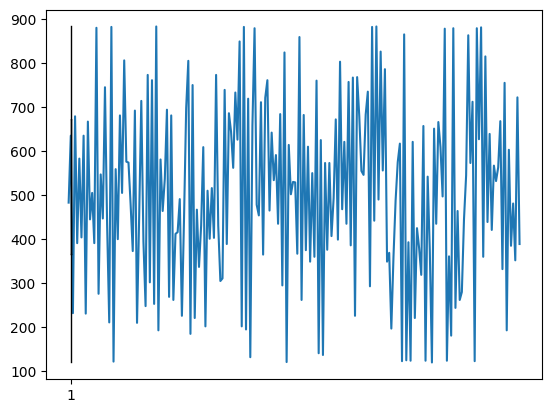

In [15]:
# A_0531_215414.info()
plt.plot(A_0531_215414)
plt.show()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

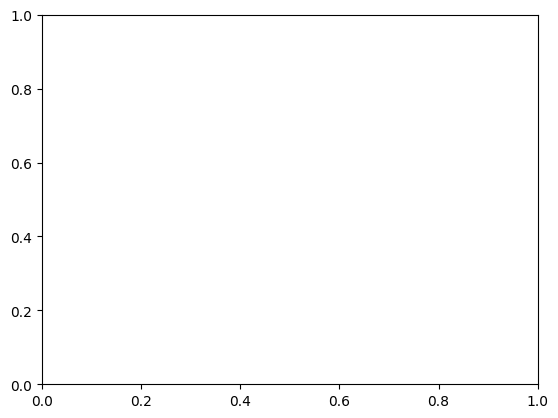

In [34]:
plt.boxplot(A_0531_215414)
plt.show()
# meanval = statistics.mean(A_0531_215414)
# medival = statistics.median(A_0531_215414)
# quantval = statistics.quantiles(A_0531_215414, n=4)